In [1]:
install.packages('cowplot')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Introduction
   Heart disease is caused by the buildup of cholesterol and other substances on the walls of the arteries that supply blood to the heart. This buildup will cause the inside of the arteries to narrow over time, which blocks blood flow to the heart. Heart disease can lead to complications such as heart attacks, strokes, aneurysms and heart failure. Heart disease is thought to be present when the diameter of the arteries have narrowed by more than 50% over time. Many factors can contribute to the development of heart disease. Some common risk factors are high blood pressure, high cholesterol and aging. High cholesterol can lead to the buildup of cholesterol in the arteries, and high blood pressure can cause arteries to become less elastic, which can prevent blood flow to the heart, increasing the risk of heart disease. Aging can result in an increased risk of damaged or narrowed arteries, which can increase the risk of heart disease. 

   We will be using a heart disease dataset from Cleveland that has information on 303 patients with 14 columns of various medical information to try and predict an individual's diagnosis of heart disease. The class we're predicting is whether or not heart disease is present in the individual based on how much the diameter of their arteries have narrowed.

## Question 
What is the diagnosis of heart disease of an individual from Cleveland?

# Data Wrangling

First, we need to read and clean the data. We can remove any NA values and add column names for readability.

In [3]:
#Read the data from the webpage into Jupyter
heart_disease <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
#Add column names based on the information given by the dataset webpage (to improve readability)
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "resting_blood_pressure", "chol", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "ST_level", "slope", "number_of_major_vessels", "thal", "diagnosis_of_heart_disease")
#Select chosen predictor and class variables 
heart_data <- heart_disease |> mutate(diagnosis = as_factor(diagnosis_of_heart_disease)) |> select(age, resting_blood_pressure, chol, ST_level, diagnosis)
#Check to see if there are any NA values
which(is.na(heart_data))
    #There aren't any NA values (the function returned no positions with missing values)

head(heart_data, n =8)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


integer(0)

age,resting_blood_pressure,chol,ST_level,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,2.3,0
67,160,286,1.5,2
67,120,229,2.6,1
37,130,250,3.5,0
41,130,204,1.4,0
56,120,236,0.8,0
62,140,268,3.6,3
57,120,354,0.6,0


**Table 1: Preview of predictor values for 8 random patients**

Since we plan on doing classification of 2 categories, we can change all non-zero values of diagnosis into $1$ to indicate that heart disease is present. Afterwards, we can split it into training and testing datasets.

In [4]:
#Setting the seed to make results of the model reproducible and reusable
set.seed(2022)
#Assign all values, 1-4, as "1" to indicate that there is a heart disease
heart_data["diagnosis"][heart_data["diagnosis"] == "2"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "3"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "4"] <- "1"
    #Source for code: https://www.statology.org/replace-values-in-data-frame-r/
#Split data into training and testing data; 75:25 split was chosen arbitrarily
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

For our exploratory data analysis, we can summarize our training data to see the number of observations for each category as well as the means of the predictors.

In [5]:
#Find the number of observations for each class (heart disease = 1 or no heart disease = 0) as well as the mean of each predictor
heart_summary <- heart_train |> group_by(diagnosis) |> summarize(number_of_observations = n(), mean_bp = mean(resting_blood_pressure), mean_chol = mean(chol), mean_st = mean(ST_level))
heart_summary

diagnosis,number_of_observations,mean_bp,mean_chol,mean_st
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,123,129.5691,239.9187,0.601626
1,104,133.6058,250.9135,1.523077


**Table 2: Distribution of heart disease within patients and average values for predictor in function of presence of heart disease**

From this table, we see that the number of observations for each diagnosis are roughly equal, meaning that KNN classification would work well. There also appears to be a difference between means of predictors for each category.

We can visualize the distributions of each predictor by plotting histograms and grouping by diagnosis

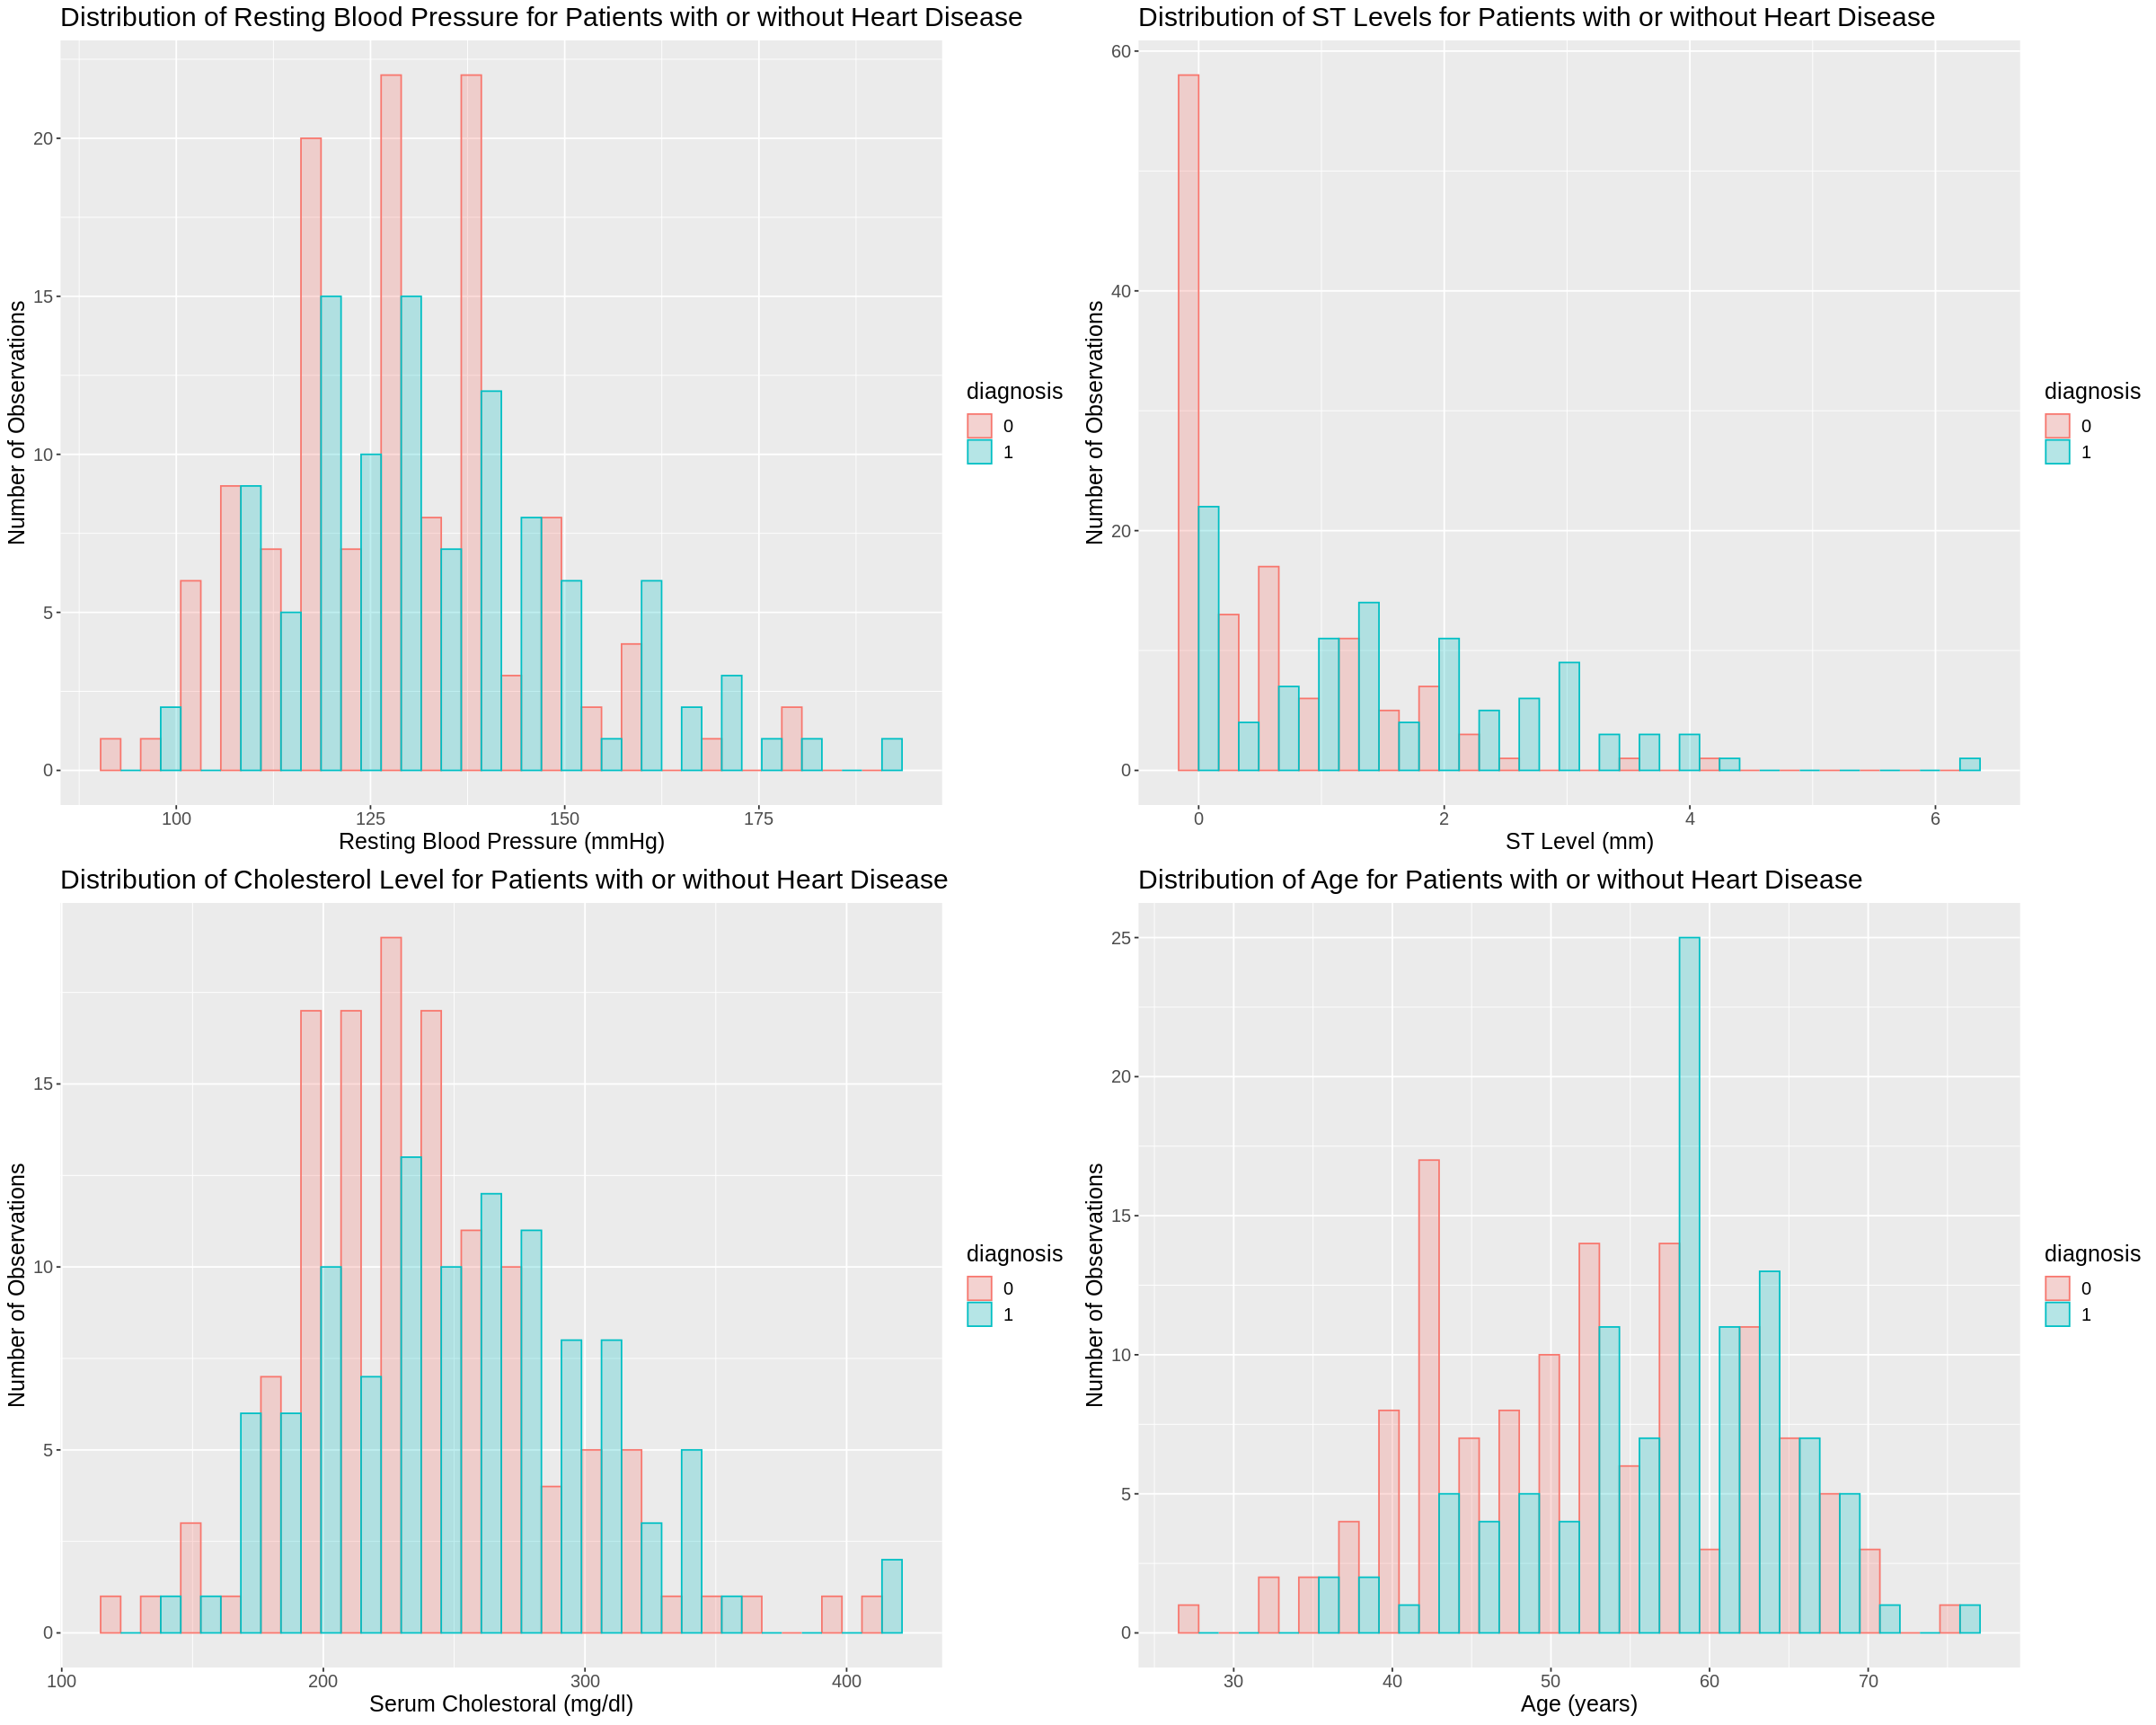

In [6]:
options(repr.plot.width = 20, repr.plot.height=16)
bp_distribution <- ggplot(heart_train, aes(x = resting_blood_pressure, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25, position = "dodge") + labs(x = "Resting Blood Pressure (mmHg)", y = "Number of Observations") + ggtitle("Distribution of Resting Blood Pressure for Patients with or without Heart Disease")+theme(text=element_text(size=15))
                     
chol_distribution <- ggplot(heart_train, aes(x = chol, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25, position = "dodge") + labs(x ="Serum Cholestoral (mg/dl)", y = "Number of Observations") +  ggtitle("Distribution of Cholesterol Level for Patients with or without Heart Disease")+theme(text=element_text(size=15))

age_distribution <- ggplot(heart_train, aes(x = age, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25, position = "dodge") + labs(x= "Age (years)", y = "Number of Observations") + ggtitle("Distribution of Age for Patients with or without Heart Disease")+theme(text=element_text(size=15))

st_distribution <- ggplot(heart_train, aes(x = ST_level, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25, position = "dodge") + labs(x = "ST Level (mm)", y = "Number of Observations") + ggtitle("Distribution of ST Levels for Patients with or without Heart Disease")+theme(text=element_text(size=15))

plot_grid(bp_distribution, st_distribution, chol_distribution, age_distribution)


**Figure 1: Distribution of disease within patients**

This grid plot was made by combining 4 histogram plots of age, cholesterol, ST level and resting blood pressure with `plot_grid()` . In each of these plots, each bar is filled by the proportion of patients with heart disease in the subset each bar represents.
<p>&nbsp;</p>
In these plots, we can see that the prevalence of patients with heart disease increases as the resting blood pressure, ST levels and age increases. For example, patients with ST level higher than 3 are almost always going to have heart disease, and patients with resting blood pressure above 160 mmHg or are older than 55 years old are more likely to be diagnosed with heart disease. However, there seems to be no distinct relationship between cholesterol and heart disease (i.e., the distribution trend for patients with heart disease and patients without are similar). Therefore, we will exclude cholesterol from one of our predictors.
<p>&nbsp;</p>

## Model Building & Choosing Best K

We want to create a KNN model which can classify heart diagnosis based on the three predictors above. First, we need to identify the best $k$ value which will give us the most accurate results. To do that, we create a tuning model with `tune()` as well as a recipe to fit that model to our training data. We need to set a seed to ensure the reproducibility of our code.

In [7]:
set.seed(2023)
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")
knn_recipe <- recipe(diagnosis~ST_level+resting_blood_pressure+age, data = heart_train) |> step_scale(all_predictors()) |> step_center(all_predictors())

Now, we use cross-validation with our training data to find the $k$ value which has the highest accuracy. We tested 20 values of $k$, from 1 to 20, and obtained a dataframe with the accuracy of each $k$ value.

In [8]:
#Create folds (10 folds was chosen arbitrarily)
data_fold <- vfold_cv(heart_train, v = 10, strata = diagnosis)
k_values<-tibble(neighbors=seq(from=1, to=20, by=2))
#Fit with model to create table of k-values and accuracies
best_k <- workflow() |> add_model(knn_spec_tune) |> add_recipe(knn_recipe) |> tune_grid(data_fold, grid = k_values)|> collect_metrics()
head(best_k)

! Fold01: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold02: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold03: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold05: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold07: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5947958,10,0.02344506,Preprocessor1_Model01
1,roc_auc,hand_till,0.5898660,10,0.02405466,Preprocessor1_Model01
3,accuracy,multiclass,0.5995553,10,0.03584433,Preprocessor1_Model02
3,roc_auc,hand_till,0.6200146,10,0.03832038,Preprocessor1_Model02
5,accuracy,multiclass,0.6440382,10,0.03555387,Preprocessor1_Model03
5,roc_auc,hand_till,0.6614744,10,0.03580670,Preprocessor1_Model03


**Table 3: Accuracy of traning model on first k values**

We can graph the accuracy of each $k$ value to determine the $k$ value with the highest accuracy in the training model.

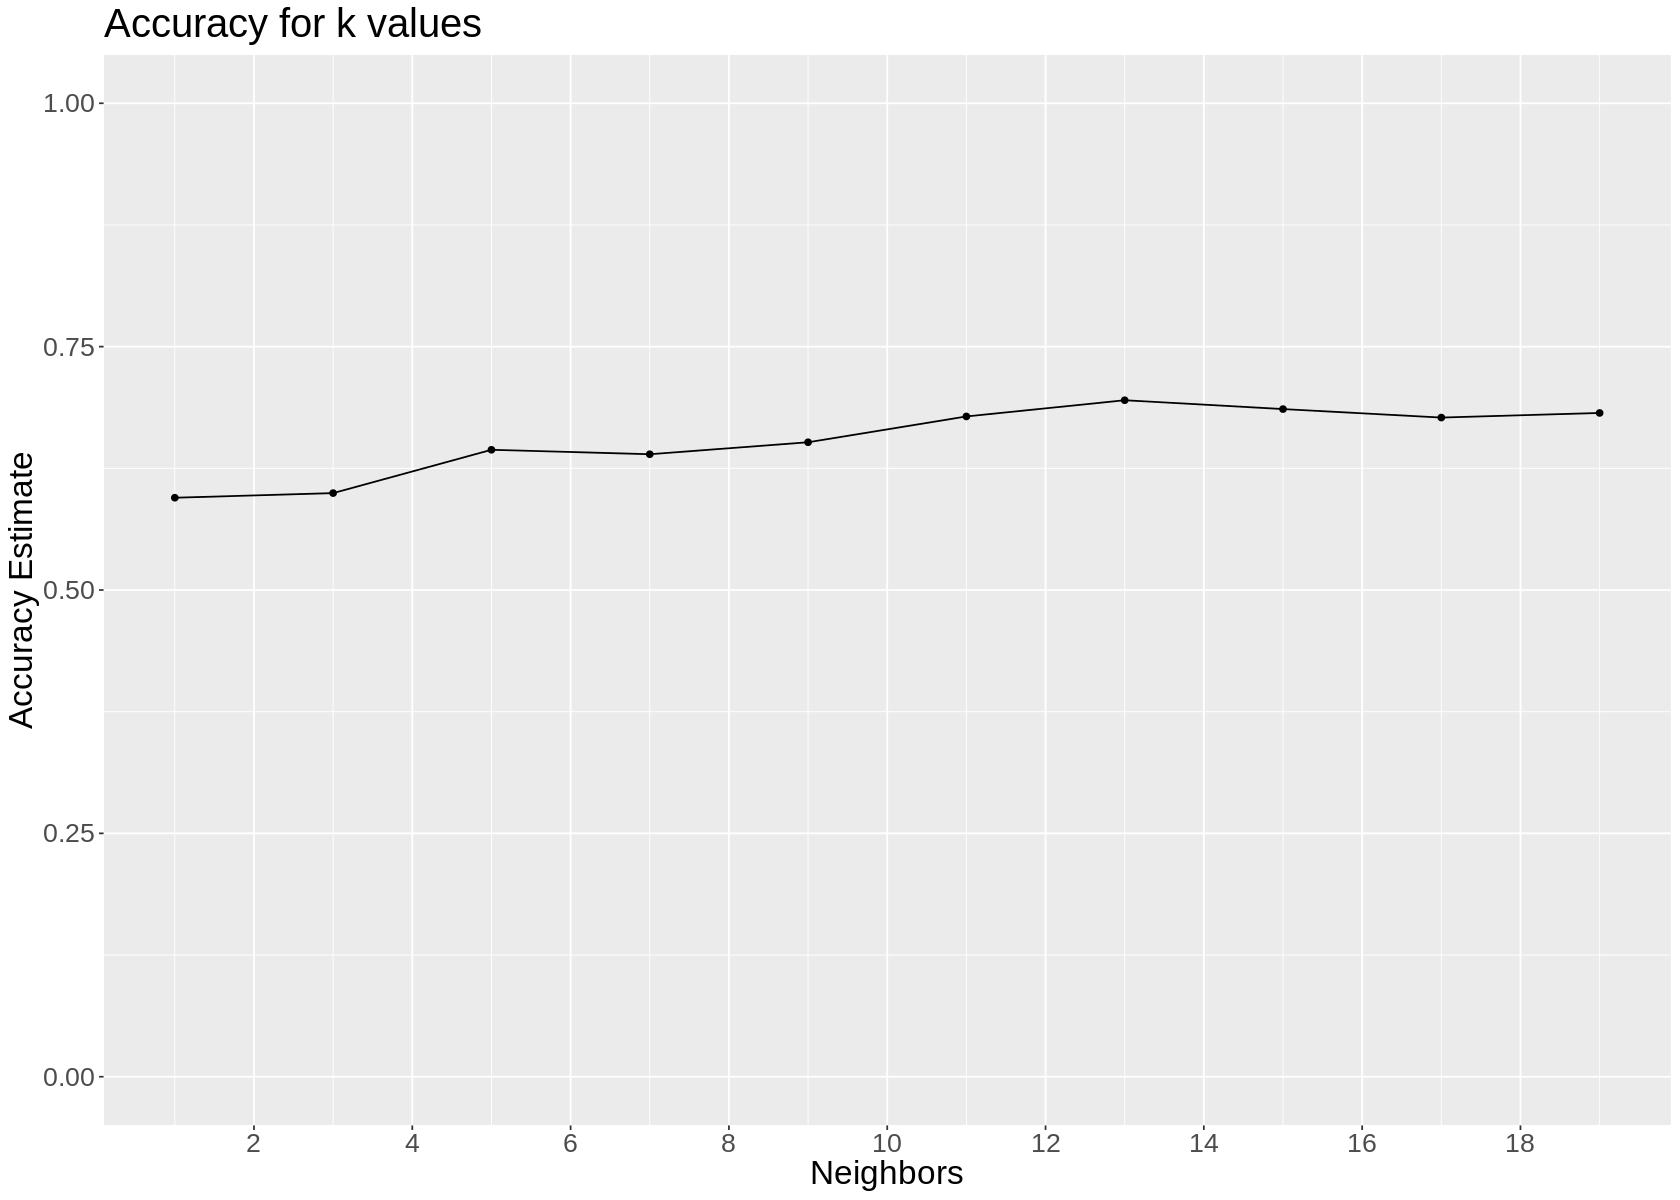

In [16]:
#we choose the best k parameter
options(repr.plot.width = 14, repr.plot.height=10)
accuracy_plot <- best_k |> filter(.metric == "accuracy") |> ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() + labs(title='Accuracy for k values', x = "Neighbors", y = "Accuracy Estimate") +
     scale_x_continuous(breaks = seq(0, 20, by = 2)) + 
     scale_y_continuous(limits = c(0, 1.0))+
theme(text=element_text(size=20))
accuracy_plot

**Figure 2: Accuracy of model for different K values**


From the graph, we see that `k = 13` produces the highest accuracy, but we double check to make sure:

In [10]:
#Find the k value with the maximum accuracy
k_model<-best_k|>filter(.metric=='accuracy')|>filter(mean==max(mean))|>select(neighbors)|>pull()
k_model

[1] 13

Finally, we can make a final model using the best k-value (13).

In [11]:
#Now we make the final model with k = 13
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_model) |> set_engine("kknn") |> set_mode("classification")
knn_recipe <- recipe(diagnosis~ST_level+resting_blood_pressure+age, data = heart_train) |> step_scale(all_predictors()) |> step_center(all_predictors())
knn_fit <- workflow() |> add_model(knn_spec) |> add_recipe(knn_recipe) |> fit(heart_train)

## Model Evaluation

We can evaluate the accuracy of our model using `predict()` on our testing data.

In [12]:
prediction <- predict(knn_fit, heart_test) |> bind_cols(heart_test)
accuracy <- metrics(prediction, truth = diagnosis, estimate = .pred_class)|>filter(.metric=='accuracy')
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7236842


**Table 2: Accuracy of best training model on testing data**

Our model has an accuracy of 72%.

## Visualizing Results

A plot of the diagnosis and the prediction will be produced to visualize relationships between predictors as well as compare the predictions to the actual diagnosis.

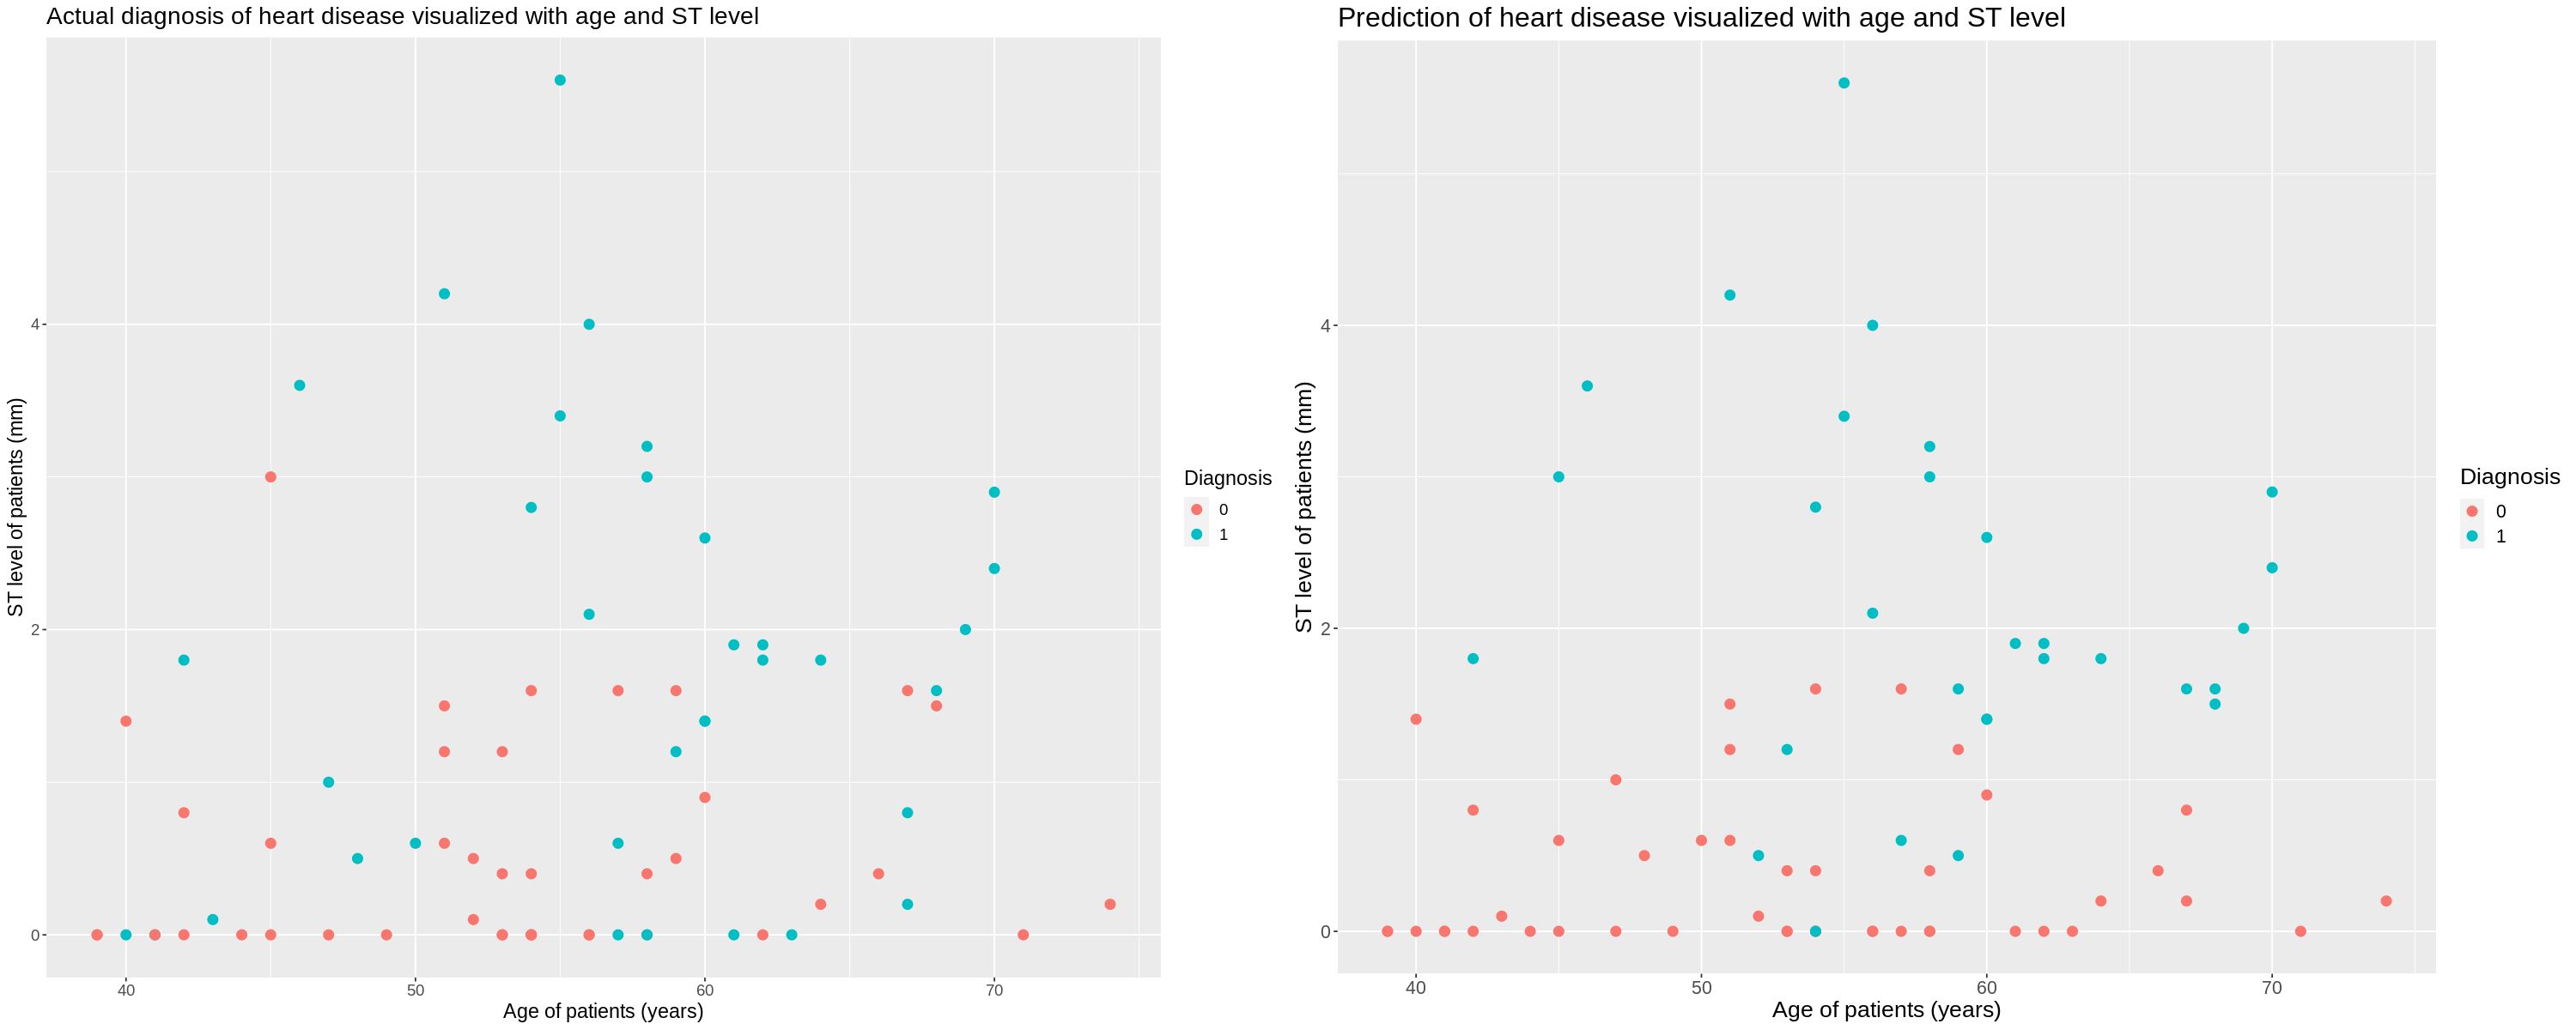

In [26]:
#Comparing the prediction for the diagnosis and the actual diagnosis
options(repr.plot.width = 25, repr.plot.height=10)
prediction_plot_age_ST<-prediction|>
ggplot(aes(x=age, y=ST_level, colour=.pred_class))+
    geom_point(size = 3)+
       labs(x='Age of patients (years)', y='ST level of patients (mm)', colour='Diagnosis')+
ggtitle('Prediction of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))


testing_plot_age_ST<-prediction|>
ggplot(aes(x=age, y=ST_level, colour=diagnosis))+
geom_point(size = 3)+
labs(x='Age of patients (years)', y='ST level of patients (mm)', colour='Diagnosis')+
ggtitle('Actual diagnosis of heart disease visualized with age and ST level')+
theme(text=element_text(size=14))

plot_grid(testing_plot_age_ST, prediction_plot_age_ST)

**Figure 3: Plots of the relationship between ST Level and Age and Heart Disease diagnosis**


As we can see from the scatterplots above, the prediction of the models are similar to the actual diagnosis
of the patients. The model appears to have most difficulty when the patient has a heart disease, but a low ST level (i.e., the most discrepancies between the prediction and the actual for patients with heart disease but low ST level).

<p>&nbsp;</p>
We will plot the diagnosis and the prediction of the model for another predictor, to see how the model performs with the other predictors. 

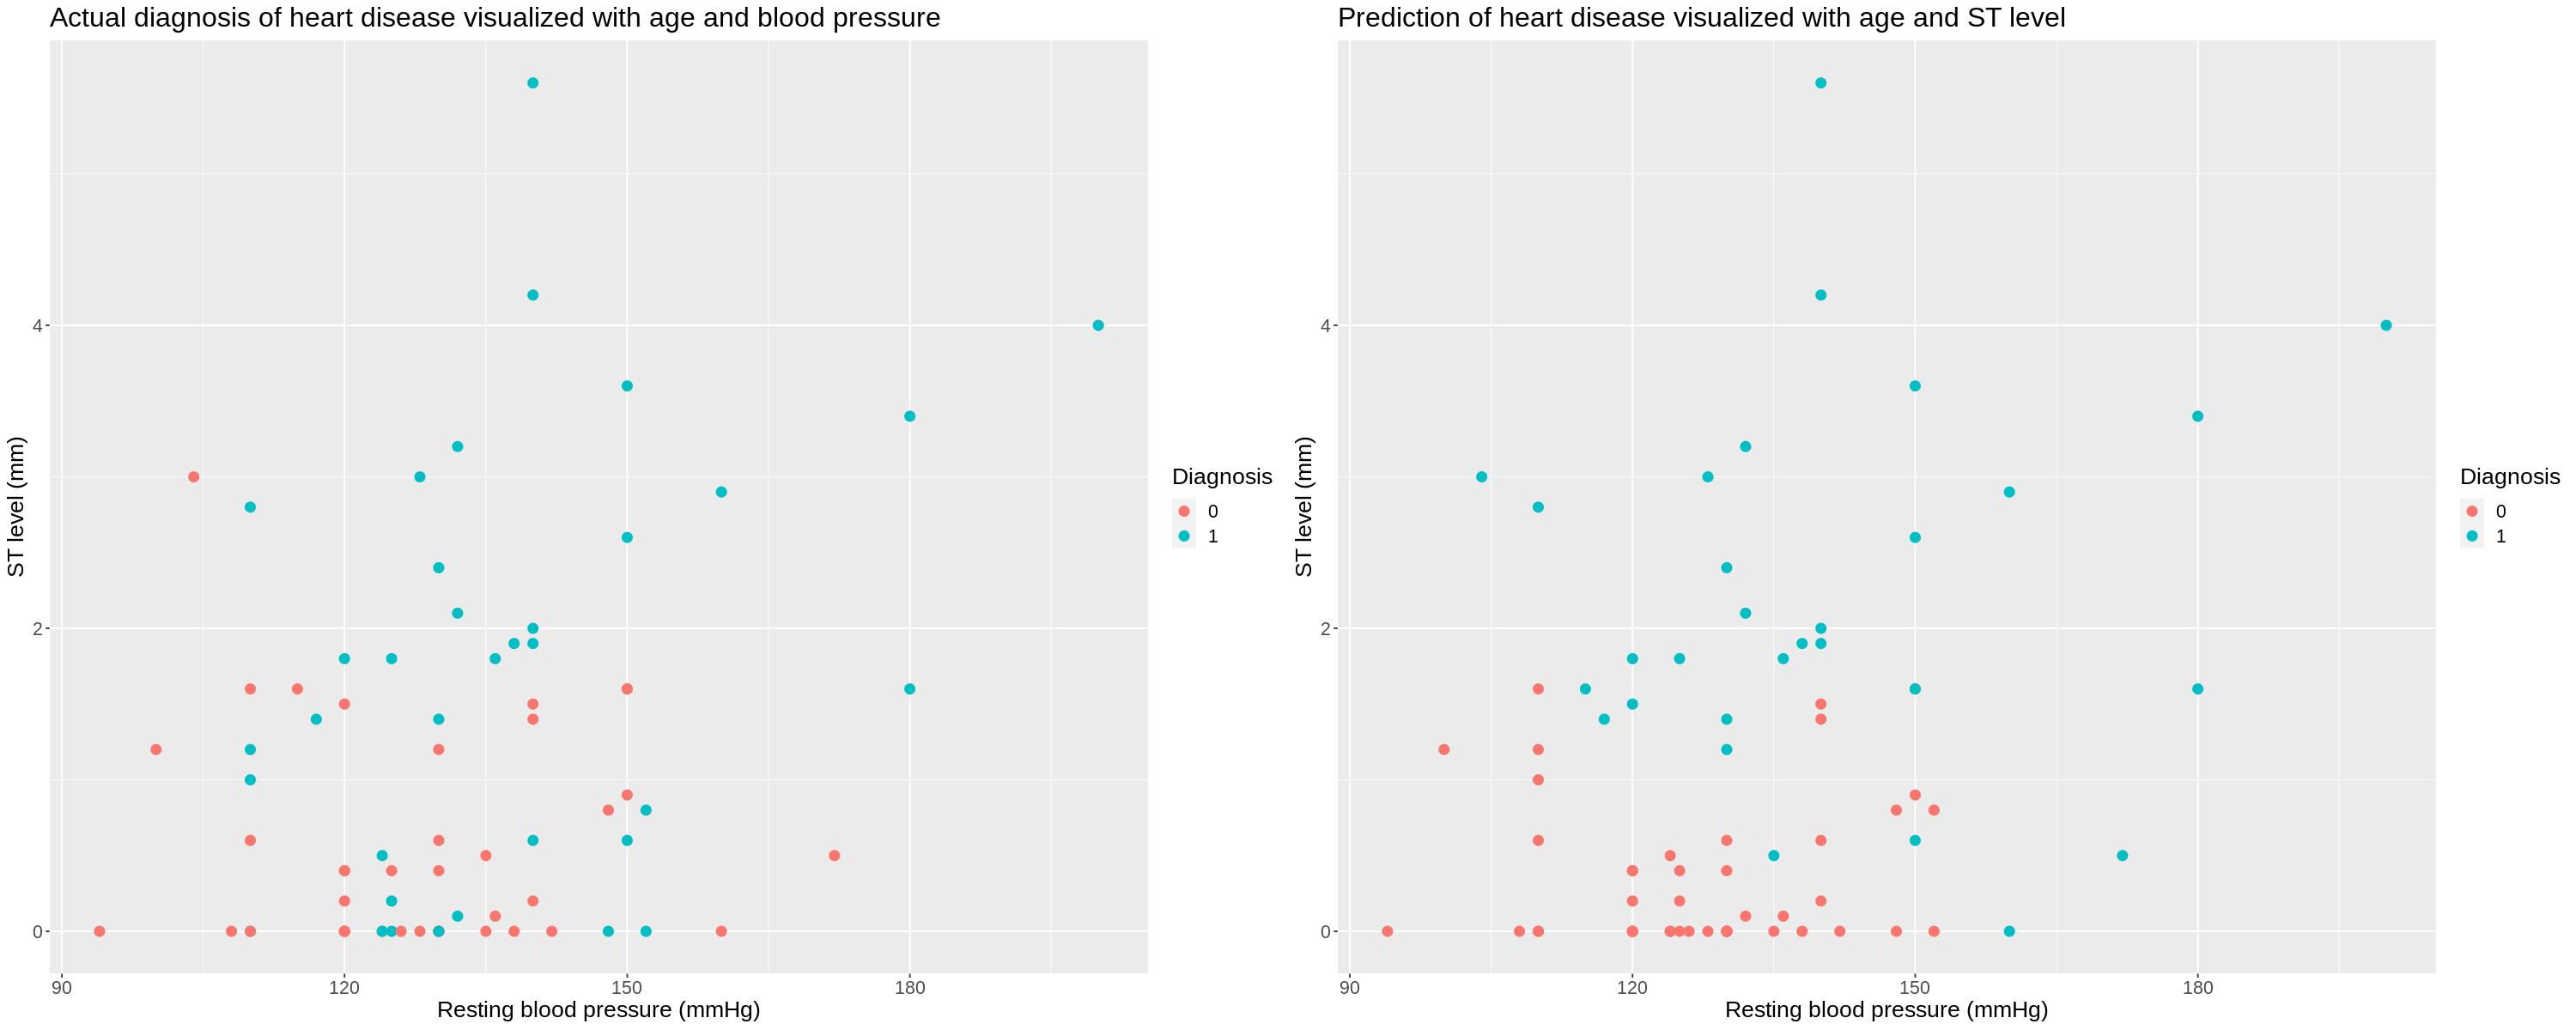

In [21]:
options(repr.plot.width = 25, repr.plot.height=10)
prediction_plot_st_bp<-prediction|>
ggplot(aes(x=resting_blood_pressure, y=ST_level, colour=.pred_class))+
    geom_point(size = 3)+
       labs(y='ST level (mm)', x='Resting blood pressure (mmHg)', colour='Diagnosis')+
ggtitle('Prediction of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))


testing_plot_st_bp<-prediction|>
ggplot(aes(y=ST_level, x=resting_blood_pressure, colour=diagnosis))+
geom_point(size = 3)+
labs(y='ST level (mm)', x='Resting blood pressure (mmHg)', colour='Diagnosis')+
ggtitle('Actual diagnosis of heart disease visualized with age and blood pressure')+
theme(text=element_text(size=16))

plot_grid(testing_plot_st_bp, prediction_plot_st_bp)

**Figure 4: Actual diagnosis in function of resting blood pressure and ST level**

Again from these two graphs, we can see that the model's predictions yield similar results to the actual diagnosis of patients.

Another takeaway that can be made from the two comparisons that were made is that the model appears to be much better at predicting the diagnosis of a patient when the ST level is really high (>2mm). As was stated earlier, the ST level is the predictor that has the strongest relationship with the prevalence of heart disease.

# Disscussion

We found that our model was able to predict the diagnosis of heart disease with around 72% accuracy. Although our model’s accuracy was decently high, it was limited because a lot of details about the individuals were not known or taken into account. Factors such as sex, ethnicity, family history and lifestyle could possibly also play a role in whether or not an individual will develop heart disease, so our model cannot be 100% accurate if these factors are not considered. 

Through the data visualizations, we discovered that ST levels has the strongest correlation with the heart disease diagnosis of an individual in Cleveland out of all of our predictors. We found that patients with an ST level higher than 3 are almost always going to have heart disease. We also found that patients with a resting blood pressure above 160 mm Hg, or who are older than 55 years old are more likely to be diagnosed with heart disease.


We expected that as age, cholesterol, resting blood pressure and ST level increase, so will the prevalence of heart disease. Thus, the presence of heart disease could be predicted by evaluating these health factors. From the visualizations, we were right in assuming that age, resting blood pressure and ST levels would play a role in predicting the diagnosis. However, we saw that cholesterol did not play a huge role. 


### Impact 
Heart Disease is the leading cause of death for men, women and people of most racial and ethnic groups in the United States. If the model can predict heart disease with high accuracy it could serve as a tool in the diagnosis of heart disease, and the prevention of some of these deaths. Our model was able to help us answer our initial question, but the results that we obtained lead to many new questions, such as:

What are some other factors that can impact the diagnosis of an individual?

How would we factor in the individual experiences or health of a person (such as genes, or family history of heart disease)?

How much impact do the eating habits and lifestyle of an individual have on the diagnosis?

Should preventative measures be taken for high-risk individuals based on these predictors?

How can we reach a higher accuracy?


These could be explored further in future research.


# References

https://www.cdc.gov/heartdisease/coronary_ad.htm

https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=Your%20body%20needs%20cholesterol%20to,to%20flow%20through%20your%20arteries.

https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-2035311

https://archive.ics.uci.edu/ml/datasets/Heart+Disease
